# Training Bert and Roberta for classifications

**Import Libraries**

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import kagglehub


**Import IMDB dataset and preprocess**

In [ ]:
def load_imdb_data(data_file):
  df = pd.read_csv(data_file)
  texts = df['review'].tolist()
  labels = [1 if sentiment == 'positive' else 0 for sentiment in df['sentiment'].tolist()]
  return texts, labels

In [ ]:
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
path = "/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"

print("Path to dataset file:", path)
texts, labels = load_imdb_data(path)

Path to dataset file: /kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


**Custom dataset class for text classification**

In [ ]:
class TextClassificationDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
    return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

**Custom BERT classifier**

In [ ]:
class BERTClassifier(nn.Module):
  def __init__(self, bert_model_name, num_classes):
    super(BERTClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(bert_model_name)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = self.fc(x)
    return logits

**Define train function**

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
  model.train()
  for batch in data_loader:
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    loss = nn.CrossEntropyLoss()(outputs, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

**Build evaluation method**

In [ ]:
def evaluate(model , data_loader, device):
  model.eval()
  predictions = []
  actual_lables = []
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      predictions.extend(preds.cpu().tolist())
      actual_lables.extend(labels.cpu().tolist())

  return accuracy_score(actual_lables, predictions), classification_report(actual_lables, predictions,output_dict = True)

**Build prediction method**

In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return "positive" if preds.item() == 1 else "negative"

**Define model's parameters**

In [ ]:
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

**Load and split the data**

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

**Init tokenizer, dataset, data loader**

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Set up the device and model**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifier(bert_model_name, num_classes).to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**Set up optimizer and learning rate scheduler**

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

**Train the model**

In [ ]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/4
Validation Accuracy: 0.8879
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      4961
           1       0.87      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Epoch 2/4
Validation Accuracy: 0.8956
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4961
           1       0.89      0.90      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Epoch 3/4
Validation Accuracy: 0.8932
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      4961
           1       0.91      0.88      0.89      5039

    accuracy                           0.89     10000
   macro avg  

**Saving the final bert model**

In [ ]:
torch.save(model.state_dict(), 'bert_classifier.pth')

**Custom RoBERTa classifier**

In [ ]:
from transformers import RobertaTokenizer, RobertaModel

class RoBERTaClassifier(nn.Module):
  def __init__(self, roberta_model_name, num_classes):
    super(RoBERTaClassifier, self).__init__()
    self.roberta = RobertaModel.from_pretrained(roberta_model_name)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.roberta.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = self.fc(x)
    return logits


**RoBERTa model training**

In [ ]:
print("\n" + "="*30)
print("Training RoBERTa")
print("="*30)

roberta_model_name = 'roberta-base'
roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_name)

train_dataset_roberta = TextClassificationDataset(train_texts, train_labels, roberta_tokenizer, max_length)
val_dataset_roberta = TextClassificationDataset(val_texts, val_labels, roberta_tokenizer, max_length)
train_dataloader_roberta = DataLoader(train_dataset_roberta, batch_size=batch_size, shuffle=True)
val_dataloader_roberta = DataLoader(val_dataset_roberta, batch_size=batch_size)

roberta_model = RoBERTaClassifier(roberta_model_name, num_classes).to(device)

roberta_optimizer = AdamW(roberta_model.parameters(), lr=learning_rate)
total_steps_roberta = len(train_dataloader_roberta) * num_epochs
roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, num_warmup_steps=0, num_training_steps=total_steps_roberta)



Training RoBERTa


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(roberta_model, train_dataloader_roberta, roberta_optimizer, roberta_scheduler, device)
    accuracy, report = evaluate(roberta_model, val_dataloader_roberta, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

**Saving the final RoBERTa model**

In [ ]:
torch.save(roberta_model.state_dict(), 'RoBERTa_classifier.pth')

**In order to load model later:**

*Im saving only the model weight


```
roberta_model = RoBERTaClassifier('roberta-base', num_classes)
roberta_model.load_state_dict(torch.load('RoBERTa_classifier.pth'))
roberta_model.to(device)
roberta_model.eval()
```



**Save Weight to computer**

In [ ]:
from google.colab import files
files.download('bert_classifier.pth')
files.download('RoBERTa_classifier.pth')

FileNotFoundError: Cannot find file: bert_classifier.pth

# Merging using TA

**Load Weight**

GPU....

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

roberta_model = RoBERTaClassifier('roberta-base', num_classes)

roberta_path = '/content/drive/MyDrive/Colab Notebooks/RoBERTa_classifier.pth'
bert_path = '/content/drive/MyDrive/Colab Notebooks/bert_classifier.pth'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
roberta_model1 = RoBERTaClassifier('roberta-base', num_classes)
roberta_model1.load_state_dict(torch.load(roberta_path, map_location=torch.device('cpu')))
roberta_model1.to(device)
roberta_model1.eval()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaClassifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

In [ ]:
bert_model1 = BERTClassifier('bert-base-uncased', num_classes)
bert_model1.load_state_dict(torch.load(bert_path, map_location=torch.device('cpu')))
bert_model1.to(device)
bert_model1.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

**Merge Using TA**


In [ ]:
import torch.nn as nn
from transformers import BertModel

def merge_models(bert_model1, roberta_model1, alpha=0.7, beta=0.3):
    assert abs(alpha + beta - 1.0) < 1e-5, "Alpha and Beta must sum to 1."

    merged_model = BERTClassifier('bert-base-uncased', num_classes=2)

    matched_params = 0
    total_params = 0

    for merged_param, param1, param2 in zip(
        merged_model.bert.parameters(),
        bert_model1.bert.parameters(),
        roberta_model1.roberta.parameters()
    ):
        total_params += 1
        if merged_param.shape != param1.shape or merged_param.shape != param2.shape:
            print(f"Skipping param due to shape mismatch: {merged_param.shape}")
            continue
        with torch.no_grad():
            merged_param.copy_(alpha * param1 + beta * param2)
            matched_params += 1

    merged_model.dropout.load_state_dict(bert_model1.dropout.state_dict())

    if bert_model1.fc.weight.shape == roberta_model1.fc.weight.shape:
        with torch.no_grad():
            merged_model.fc.weight.copy_(
                alpha * bert_model1.fc.weight + beta * roberta_model1.fc.weight
            )
            merged_model.fc.bias.copy_(
                alpha * bert_model1.fc.bias + beta * roberta_model1.fc.bias
            )
        print("✅ Successfully merged the fc/classifier layers.")
    else:
        merged_model.fc.load_state_dict(bert_model1.fc.state_dict())
        print("❌ Cannot merge fc layers: shape mismatch.")

    print(f"\n✅ Merged {matched_params}/{total_params} encoder parameters successfully.")

    return merged_model


# Evaluating
use different weight distrabution starting with bert at 40% all the way to bert at 80%

In [ ]:
results = []

for alpha in [round(x * 0.05, 2) for x in range(8, 17)]:
    beta = round(1.0 - alpha, 2)
    print(f"\n🔄 Merging with alpha={alpha:.2f}, beta={beta:.2f}")

    merged_model = merge_models(bert_model1, roberta_model1, alpha, beta)
    merged_model.to(device)

    accuracy, report = evaluate(merged_model, val_dataloader, device)

    results.append({
        'alpha': alpha,
        'accuracy': accuracy,
        'report': report
    })

    print(f"✅ Alpha={alpha:.2f} | Accuracy={accuracy:.4f}")


🔄 Merging with alpha=0.40, beta=0.60
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
✅ Successfully merged the fc/classifier layers.

✅ Merged 196/199 encoder parameters successfully.
✅ Alpha=0.40 | Accuracy=0.4945

🔄 Merging with alpha=0.45, beta=0.55
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
✅ Successfully merged the fc/classifier layers.

✅ Merged 196/199 encoder parameters successfully.
✅ Alpha=0.45 | Accuracy=0.5038

🔄 Merging with alpha=0.50, beta=0.50
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
✅ Successfully merged the fc/classifier layers.

✅ Merged 196/199 encoder par

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Alpha=0.50 | Accuracy=0.5039

🔄 Merging with alpha=0.55, beta=0.45
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
✅ Successfully merged the fc/classifier layers.

✅ Merged 196/199 encoder parameters successfully.
✅ Alpha=0.55 | Accuracy=0.5053

🔄 Merging with alpha=0.60, beta=0.40
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
✅ Successfully merged the fc/classifier layers.

✅ Merged 196/199 encoder parameters successfully.
✅ Alpha=0.60 | Accuracy=0.5473

🔄 Merging with alpha=0.65, beta=0.35
Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
✅ Successfully merged the fc/classifier layers

In [ ]:
accuracy, report = evaluate(bert_model1, val_dataloader, device)
print(f"✅ Alpha= 1 (bert model) | Accuracy={accuracy:.4f}")
results.append({
    'alpha': 1,
    'accuracy': accuracy,
    'report': report
})
accuracy, report = evaluate(roberta_model1, val_dataloader_roberta, device)
print(f"✅ Alpha= 0 (roberta model) | Accuracy={accuracy:.4f}")
results.append({
    'alpha': 0,
    'accuracy': accuracy,
    'report': report
})

✅ Alpha= 1 (bert model) | Accuracy=0.8970
✅ Alpha= 0 (roberta model) | Accuracy=0.9171


In [ ]:
print(results)

[{'alpha': 0, 'accuracy': 0.9171, 'report': {'0': {'precision': 0.9172051696284329, 'recall': 0.9155412215279177, 'f1-score': 0.916372440230001, 'support': 4961.0}, '1': {'precision': 0.9169968304278923, 'recall': 0.9186346497320897, 'f1-score': 0.9178150094180628, 'support': 5039.0}, 'accuracy': 0.9171, 'macro avg': {'precision': 0.9171010000281625, 'recall': 0.9170879356300037, 'f1-score': 0.9170937248240318, 'support': 10000.0}, 'weighted avg': {'precision': 0.9171001875052803, 'recall': 0.9171, 'f1-score': 0.9170993508438653, 'support': 10000.0}}}, {'alpha': 0.4, 'accuracy': 0.4945, 'report': {'0': {'precision': 0.47875226039783003, 'recall': 0.2134650272122556, 'f1-score': 0.2952739439565036, 'support': 4961.0}, '1': {'precision': 0.4989727786337956, 'recall': 0.7711847588807303, 'f1-score': 0.6059094098386216, 'support': 5039.0}, 'accuracy': 0.4945, 'macro avg': {'precision': 0.48886251951581283, 'recall': 0.49232489304649296, 'f1-score': 0.45059167689756263, 'support': 10000.0},

**Graph & Plots**

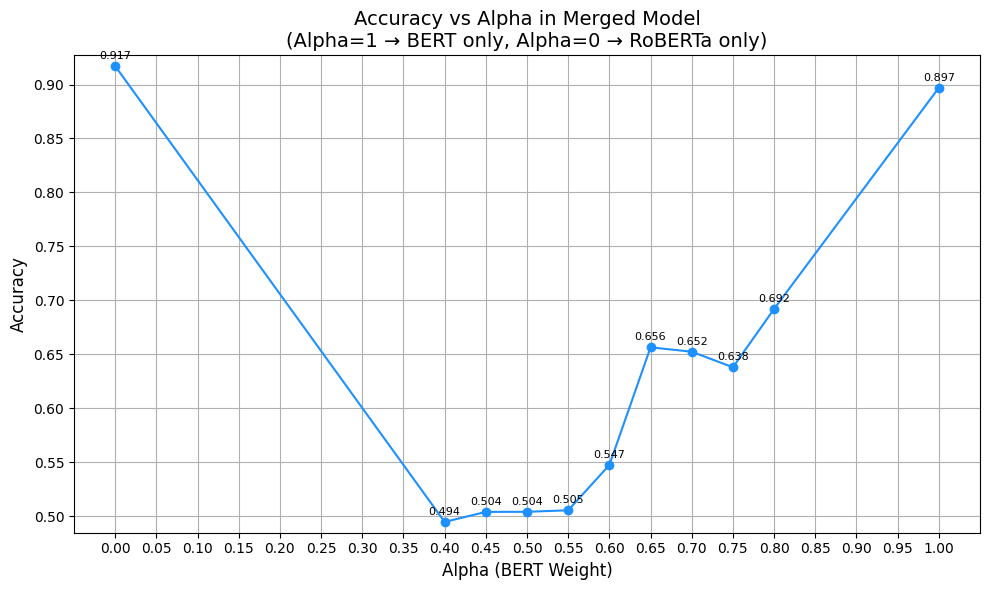

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

results = sorted(results, key=lambda x: x['alpha'])

alphas = [entry['alpha'] for entry in results]
accuracies = [entry['accuracy'] for entry in results]

plt.figure(figsize=(10, 6))
plt.plot(alphas, accuracies, marker='o', linestyle='-', color='dodgerblue')
plt.title("Accuracy vs Alpha in Merged Model\n(Alpha=1 → BERT only, Alpha=0 → RoBERTa only)", fontsize=14)
plt.xlabel("Alpha (BERT Weight)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(np.arange(0.0, 1.05, 0.05))
plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01)

for alpha, acc in zip(alphas, accuracies):
    plt.annotate(f"{acc:.3f}", (alpha, acc), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

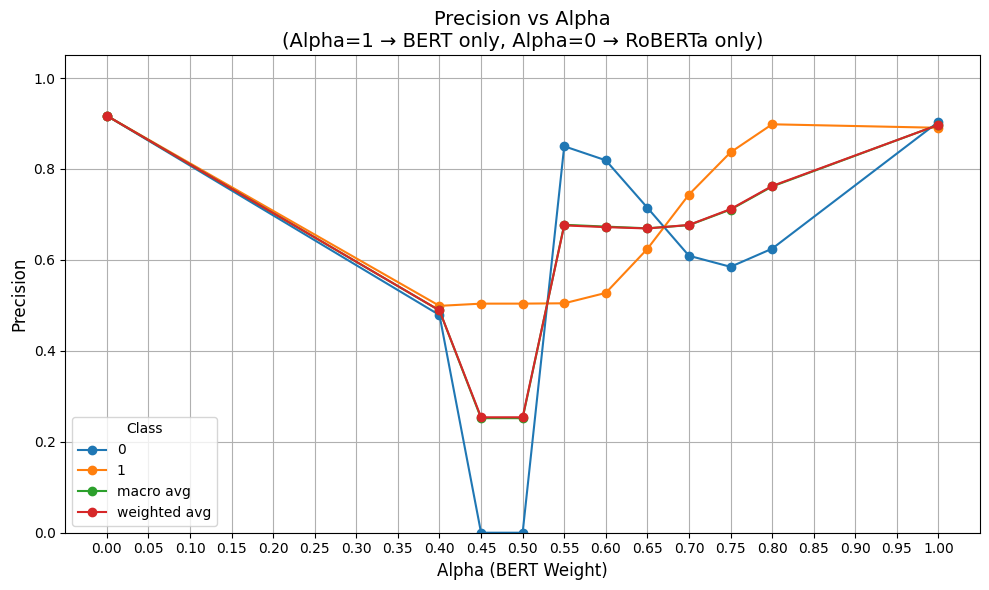

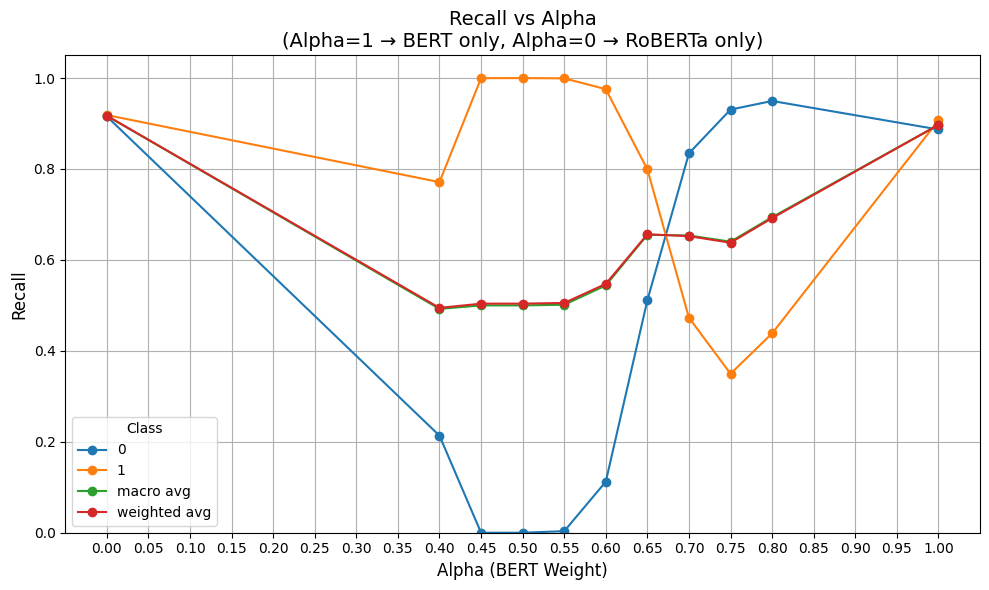

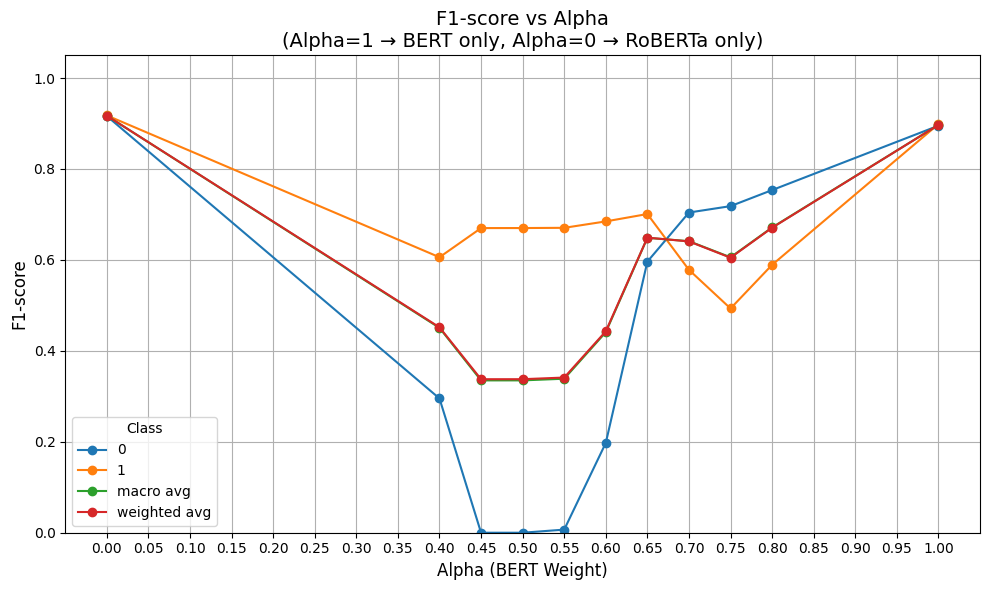

In [ ]:
classes = ['0', '1', 'macro avg', 'weighted avg']
metrics = ['precision', 'recall', 'f1-score']

metric_data = {cls: {metric: [] for metric in metrics} for cls in classes}
alphas = []

for entry in sorted(results, key=lambda x: x['alpha']):
    report = entry['report']
    alpha = entry['alpha']
    alphas.append(alpha)
    for cls in classes:
        for metric in metrics:
            metric_data[cls][metric].append(report[cls][metric])

for metric in metrics:
    plt.figure(figsize=(10, 6))
    for cls in classes:
        plt.plot(alphas, metric_data[cls][metric], marker='o', label=f"{cls}")
    plt.title(f"{metric.capitalize()} vs Alpha\n(Alpha=1 → BERT only, Alpha=0 → RoBERTa only)", fontsize=14)
    plt.xlabel("Alpha (BERT Weight)", fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.legend(title="Class")
    plt.ylim(0, 1.05)
    plt.xticks(np.arange(0.0, 1.05, 0.05))
    plt.tight_layout()
    plt.show()


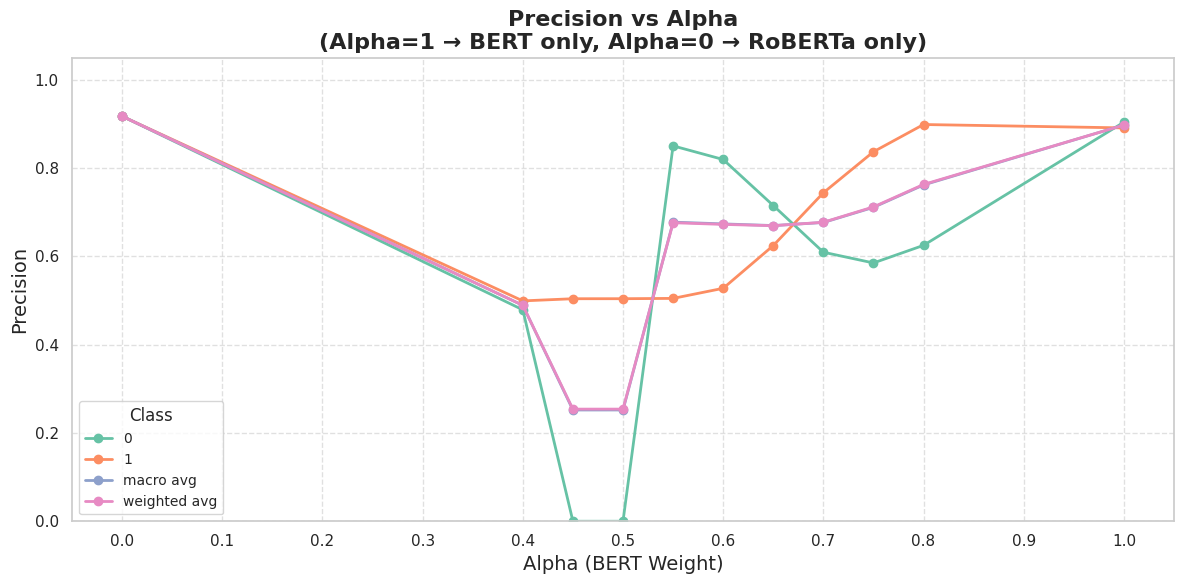

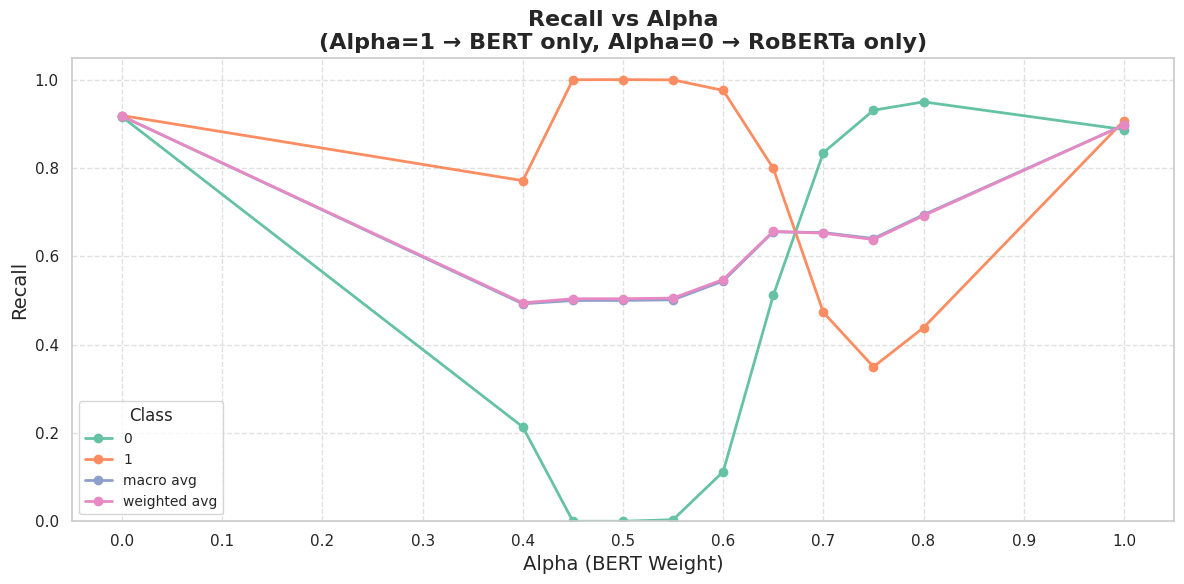

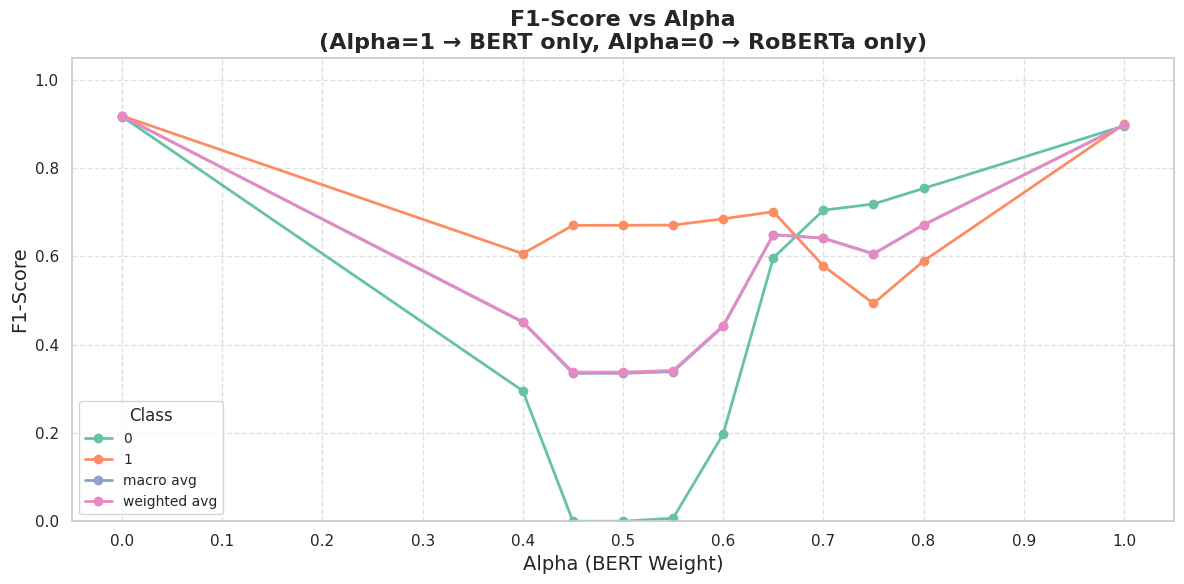

In [ ]:
import seaborn as sns

# Optional: use a better aesthetic style
sns.set(style="whitegrid", context="notebook", palette="Set2")

# Data structure setup (same as yours)
classes = ['0', '1', 'macro avg', 'weighted avg']
metrics = ['precision', 'recall', 'f1-score']
metric_data = {cls: {metric: [] for metric in metrics} for cls in classes}
alphas = []

# Fill data
for entry in sorted(results, key=lambda x: x['alpha']):
    report = entry['report']
    alpha = entry['alpha']
    alphas.append(alpha)
    for cls in classes:
        for metric in metrics:
            metric_data[cls][metric].append(report[cls][metric])

# Plotting
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for cls in classes:
        plt.plot(alphas, metric_data[cls][metric], marker='o', label=cls, linewidth=2)

    plt.title(f"{metric.title()} vs Alpha\n(Alpha=1 → BERT only, Alpha=0 → RoBERTa only)", fontsize=16, fontweight='bold')
    plt.xlabel("Alpha (BERT Weight)", fontsize=14)
    plt.ylabel(metric.title(), fontsize=14)
    plt.ylim(0, 1.05)
    plt.xticks(np.round(np.linspace(0, 1, 11), 2))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Class", fontsize=10)
    plt.tight_layout()
    plt.show()


# Merging with SLERP


In [ ]:
import torch.nn.functional as F

def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    v0_norm = F.normalize(v0, dim=0)
    v1_norm = F.normalize(v1, dim=0)
    dot = torch.dot(v0_norm.view(-1), v1_norm.view(-1))

    if abs(dot) > DOT_THRESHOLD:
        return F.normalize((1.0 - t) * v0 + t * v1, dim=0)

    omega = torch.acos(dot)
    sin_omega = torch.sin(omega)
    v0_coeff = torch.sin((1.0 - t) * omega) / sin_omega
    v1_coeff = torch.sin(t * omega) / sin_omega
    return v0_coeff * v0 + v1_coeff * v1


In [ ]:
def merge_models_slerp(bert_model1, roberta_model1, alpha=0.9, DOT_THRESHOLD=0.9995):
    assert 0 <= alpha <= 1, "Alpha must be between 0 and 1."

    merged_model = BERTClassifier('bert-base-uncased', num_classes=2)

    matched_params = 0
    total_params = 0

    for merged_param, param1, param2 in zip(
        merged_model.bert.parameters(),
        bert_model1.bert.parameters(),
        roberta_model1.roberta.parameters()
    ):
        total_params += 1
        if merged_param.shape != param1.shape or merged_param.shape != param2.shape:
            print(f"Skipping param due to shape mismatch: {merged_param.shape}")
            continue
        with torch.no_grad():
            merged_param.copy_(slerp(alpha, param1.data, param2.data, DOT_THRESHOLD))
            matched_params += 1

    merged_model.dropout.load_state_dict(bert_model1.dropout.state_dict())

    if bert_model1.fc.weight.shape == roberta_model1.fc.weight.shape:
        with torch.no_grad():
            merged_model.fc.weight.copy_(
                slerp(alpha, bert_model1.fc.weight.data, roberta_model1.fc.weight.data, DOT_THRESHOLD)
            )
            merged_model.fc.bias.copy_(
                slerp(alpha, bert_model1.fc.bias.data, roberta_model1.fc.bias.data, DOT_THRESHOLD)
            )
        print("✅ Successfully SLERP-merged the fc/classifier layers.")
    else:
        merged_model.fc.load_state_dict(bert_model1.fc.state_dict())
        print("❌ Cannot SLERP-merge fc layers: shape mismatch.")

    print(f"\n✅ SLERP Merged {matched_params}/{total_params} encoder parameters successfully.")

    return merged_model


In [ ]:
merged_model = merge_models_slerp(bert_model1, roberta_model1)
merged_model.to(device)

accuracy, report = evaluate(merged_model, val_dataloader, device)
print(f"accuracy: {accuracy}")
print(f"report: {report}")

Skipping param due to shape mismatch: torch.Size([30522, 768])
Skipping param due to shape mismatch: torch.Size([512, 768])
Skipping param due to shape mismatch: torch.Size([2, 768])
✅ Successfully SLERP-merged the fc/classifier layers.

✅ SLERP Merged 196/199 encoder parameters successfully.
accuracy: 0.5039
report: {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4961.0}, '1': {'precision': 0.5039, 'recall': 1.0, 'f1-score': 0.6701243433738946, 'support': 5039.0}, 'accuracy': 0.5039, 'macro avg': {'precision': 0.25195, 'recall': 0.5, 'f1-score': 0.3350621716869473, 'support': 10000.0}, 'weighted avg': {'precision': 0.25391521, 'recall': 0.5039, 'f1-score': 0.3376756566261055, 'support': 10000.0}}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
